## DAS data processing demo

Provided by [Bin Luo](mailto:luob@sustech.edu.cn) and Qipeng Bai

This notebook demo provides a simple example of reading DAS data and basic signal processing steps to handle the data, such as trimming, concatenating, detrending, common-mode noise removal, tapering, filtering, and downsamping.

The data used in this notebook was accessed from the open data repository of the RAPID experiment (https://oceanobservatories.org/pi-instrument/rapid-a-community-test-of-distributed-acoustic-sensing-on-the-ocean-observatories-initiative-regional-cabled-array/). 

## Conda environmental  

conda create -n dastools python=3.10

conda activate dastools

requirements:  
 - h5py==2.10.0
 - nptdms==1.6.0
 - numpy==1.18.5
 - scipy==1.5.0
 - segyio==1.9.9

conda install numpy scipy h5py nptdms segyio

conda install -n dastools ipykernel --update-deps --force-reinstall


In [ ]:
# !pip install -r requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp

### Read metadata from the data file

In [2]:
fname = './data/North-C2-HF-P1kHz-GL30m-Sp2m-FS500Hz_2021-11-03T082931Z.h5'
metadata = dp.read_das(fname, metadata=True)

for key in metadata.keys():
    print(key, ':', metadata[key])

dt : 0.002
nt : 15000
dx : 2.0419047
nch : 32600
GL : 30.628572
headers : {'AcquisitionId': b'89c88658-cb76-4a1a-bd85-b8e1572e49f5', 'GaugeLength': 30.628572, 'GaugeLengthUnit': b'm', 'MaximumFrequency': 250.0, 'MinimumFrequency': 0.0, 'NumberOfLoci': 32600, 'PulseRate': 1000.0, 'PulseWidth': 150.0, 'PulseWidthUnit': b'ns', 'SpatialSamplingInterval': 2.0419047, 'SpatialSamplingIntervalUnit': b'm', 'StartLocusIndex': 0, 'TriggeredMeasurement': b'false', 'VendorCode': b'OptaSense IU Setup 1.7.3 c5bde49175ee6dc70c95d4b39db648d3fda54a46', 'schemaVersion': b'2.0', 'uuid': b'89c88658-cb76-4a1a-bd85-b8e1572e49f5'}


### Read DAS raw data from the data file

In [3]:
%%time
data = dp.read_das(fname)
print(data.shape)  # data shape convention: (number of channels, number of time samples)

(32600, 15000)
CPU times: user 8.92 s, sys: 1.45 s, total: 10.4 s
Wall time: 13 s


In [4]:
%%time
data = dp.read_das(fname, ch1=5000, ch2=8000)
print(data.shape)

(3000, 15000)
CPU times: user 949 ms, sys: 231 ms, total: 1.18 s
Wall time: 1.46 s


### Preview the raw data

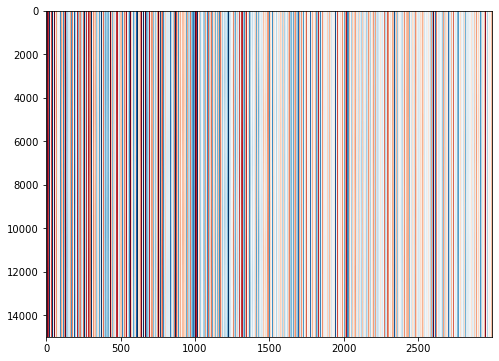

In [5]:
plt.figure(figsize=[8,6])

data_plot = data[:, :]
clim = data_plot.std() 
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim)

### Detrend data, remove common-mode noise, and plot data

In [6]:
# preprocessing / common-mode noise removal
data1 = dp.das_preprocess(data)

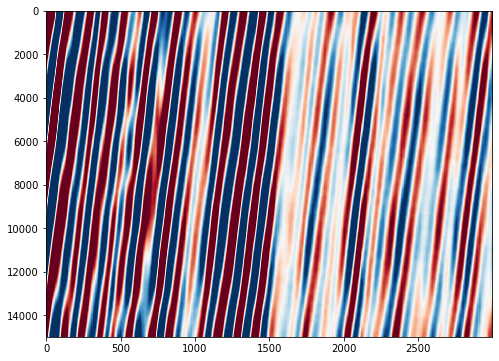

In [7]:
plt.figure(figsize=[8,6])

data_plot = data1[:, :]
clim = data_plot.std() 
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim)

### Filter and plot data

In [8]:
# data filtering (channel-by-channel)
dt = metadata['dt']
data2 = dp.tapering(data1, 0.2)
data2 = dp.highpass(data2, dt, fl=2)
data2 = dp.das_preprocess(data2)

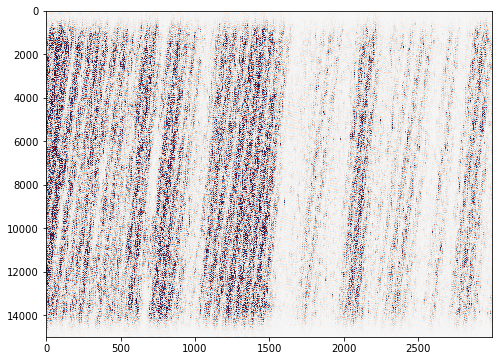

In [9]:
plt.figure(figsize=[8,6])

data_plot = data2[:, :]
clim = data_plot.std() 
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim)

### Calculate frequency spectrum

In [10]:
spec = np.fft.rfft(data1, axis=1)
faxis = np.fft.rfftfreq(data1.shape[1], metadata['dt'])

Text(0, 0.5, 'Frequency (Hz)')

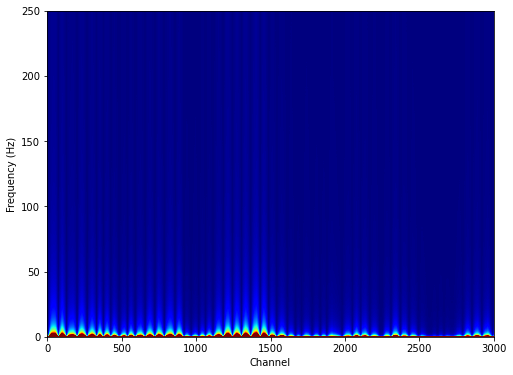

In [11]:
plt.figure(figsize=[8,6])

data_plot = abs(spec[:, :])
clim = data_plot.std() 
extent = [0, data_plot.shape[0], faxis[0], faxis[-1]]
plt.imshow(data_plot.T, aspect='auto', cmap='jet', vmin=0, vmax=clim, 
           origin='lower', extent=extent)

plt.xlabel('Channel')
plt.ylabel('Frequency (Hz)')

### FK transform

In [12]:
fk = np.fft.fftshift(np.fft.fft2(data1))
faxis = np.fft.fftshift(np.fft.fftfreq(data1.shape[1], metadata['dt']))
kaxis = np.fft.fftshift(np.fft.fftfreq(data1.shape[0], metadata['dx']))

Text(0, 0.5, 'Frequency (Hz)')

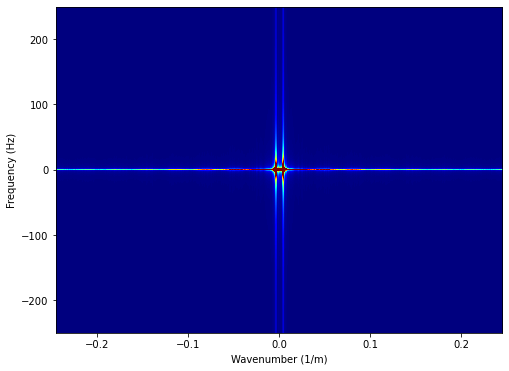

In [13]:
plt.figure(figsize=[8,6])

data_plot = abs(fk[:, :])
clim = data_plot.std() 
extent = [kaxis[0], kaxis[-1], faxis[0], faxis[-1]]
plt.imshow(data_plot.T, aspect='auto', cmap='jet', vmin=0, vmax=clim, 
           origin='lower', extent=extent)

plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')

(0.0, 0.2)

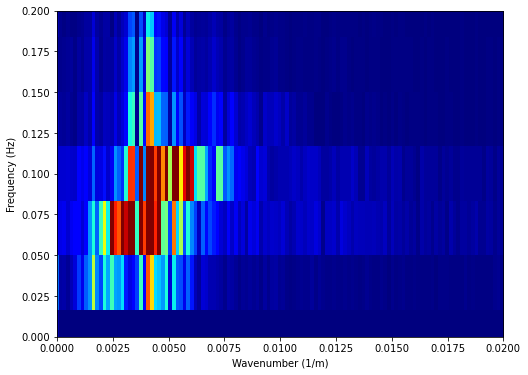

In [14]:
plt.figure(figsize=[8,6])

data_plot = abs(fk[:, :])
clim = data_plot.std() * 500
extent = [kaxis[0], kaxis[-1], faxis[0], faxis[-1]]
plt.imshow(data_plot.T, aspect='auto', cmap='jet', vmin=0, vmax=clim, 
           origin='lower', extent=extent)

plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')

plt.xlim(0,0.02)
plt.ylim(0,0.2)

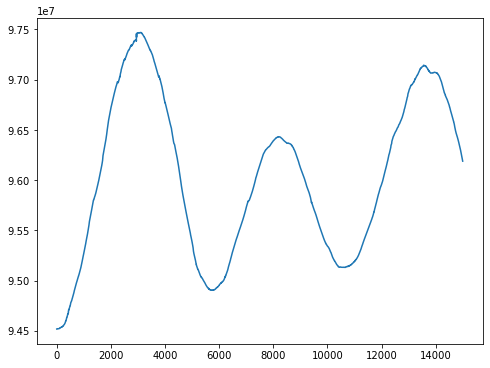

In [15]:
channel_choose = 1000

plt.figure(figsize=[8,6])
plt.plot(data[channel_choose, :])

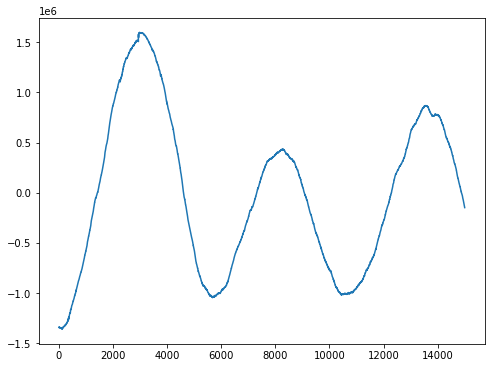

In [16]:
plt.figure(figsize=[8,6])
plt.plot(data1[channel_choose, :])

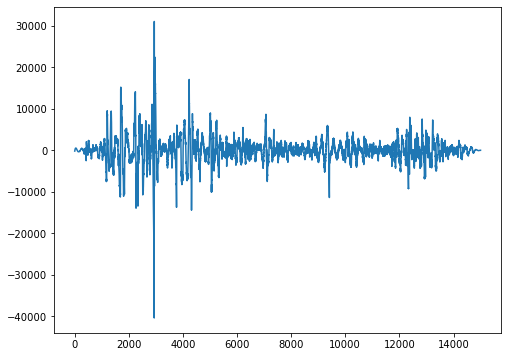

In [17]:
plt.figure(figsize=[8,6])
plt.plot(data2[channel_choose, :])

### Concatenate and decimate data

In [18]:
import glob
from scipy import signal

flist = glob.glob('./data/North*')
flist.sort()
flist

['./data/North-C2-HF-P1kHz-GL30m-Sp2m-FS500Hz_2021-11-03T082931Z.h5',
 './data/North-C2-HF-P1kHz-GL30m-Sp2m-FS500Hz_2021-11-03T083001Z.h5',
 './data/North-C2-HF-P1kHz-GL30m-Sp2m-FS500Hz_2021-11-03T083031Z.h5',
 './data/North-C2-HF-P1kHz-GL30m-Sp2m-FS500Hz_2021-11-03T083101Z.h5']

In [19]:
metadata = dp.read_das(flist[0], metadata=True)

for key in metadata.keys():
    print(key, ':', metadata[key])

dt : 0.002
nt : 15000
dx : 2.0419047
nch : 32600
GL : 30.628572
headers : {'AcquisitionId': b'89c88658-cb76-4a1a-bd85-b8e1572e49f5', 'GaugeLength': 30.628572, 'GaugeLengthUnit': b'm', 'MaximumFrequency': 250.0, 'MinimumFrequency': 0.0, 'NumberOfLoci': 32600, 'PulseRate': 1000.0, 'PulseWidth': 150.0, 'PulseWidthUnit': b'ns', 'SpatialSamplingInterval': 2.0419047, 'SpatialSamplingIntervalUnit': b'm', 'StartLocusIndex': 0, 'TriggeredMeasurement': b'false', 'VendorCode': b'OptaSense IU Setup 1.7.3 c5bde49175ee6dc70c95d4b39db648d3fda54a46', 'schemaVersion': b'2.0', 'uuid': b'89c88658-cb76-4a1a-bd85-b8e1572e49f5'}


In [20]:
%%time
datalist = []

for fname in flist:
    datalist.append(dp.read_das(fname, ch1=2000, ch2=8000))

data = np.concatenate(datalist, axis=1)

CPU times: user 8.16 s, sys: 3 s, total: 11.2 s
Wall time: 14 s


In [21]:
print(data.shape)

(6000, 60000)


In [22]:
M = 10
data = signal.decimate(data, M, axis=1)
metadata['dt'] *= M

In [23]:
print(data.shape)

(6000, 6000)


In [24]:
# preprocessing / common-mode noise removal
data1 = dp.das_preprocess(data)

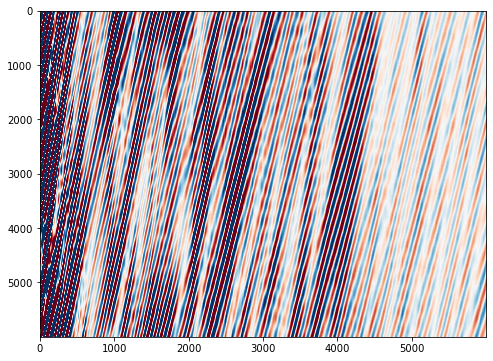

In [25]:
plt.figure(figsize=[8,6])

data_plot = data1[:, :]
clim = data_plot.std() 
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim)

In [26]:
fk = np.fft.fftshift(np.fft.fft2(data1))
faxis = np.fft.fftshift(np.fft.fftfreq(data1.shape[1], metadata['dt']))
kaxis = np.fft.fftshift(np.fft.fftfreq(data1.shape[0], metadata['dx']))

(0.0, 0.2)

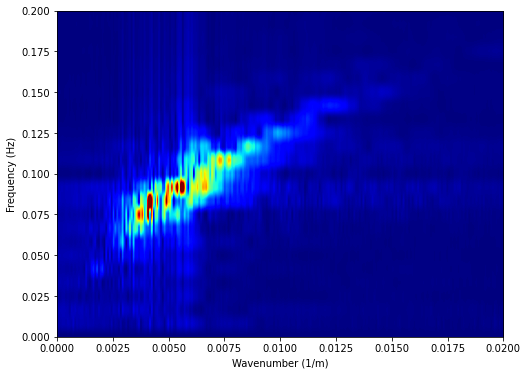

In [27]:
plt.figure(figsize=[8,6])

data_plot = abs(fk[:, :])
clim = data_plot.std() * 500
extent = [kaxis[0], kaxis[-1], faxis[0], faxis[-1]]
plt.imshow(data_plot.T, aspect='auto', cmap='jet', vmin=0, vmax=clim, 
           origin='lower', extent=extent)

plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')

plt.xlim(0,0.02)
plt.ylim(0,0.2)